In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
import skfuzzy as fuzz
from skfuzzy import control as ctrl

## Membership Functions

C:\Users\danie\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


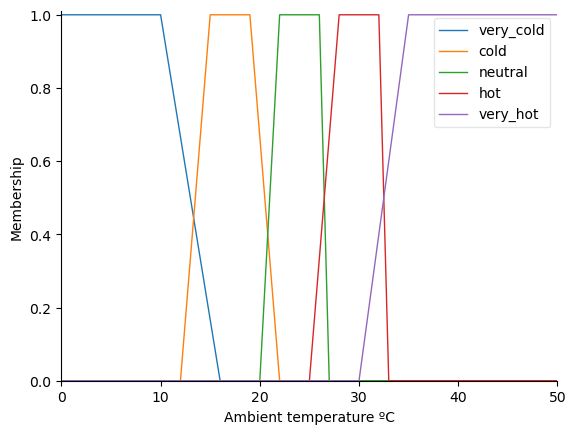

In [2]:
t_amb = ctrl.Antecedent(np.arange(0, 51, 1), 'Ambient temperature ºC')
t_amb['very_cold'] = fuzz.trapmf(t_amb.universe, [0,0,10,16])
t_amb['cold'] = fuzz.trapmf(t_amb.universe, [12,15,19,22])
t_amb['neutral'] = fuzz.trapmf(t_amb.universe, [20,22,26,27])
t_amb['hot'] = fuzz.trapmf(t_amb.universe, [25,28,32,33])
t_amb['very_hot'] = fuzz.trapmf(t_amb.universe, [30,35,50,50])
t_amb.view()

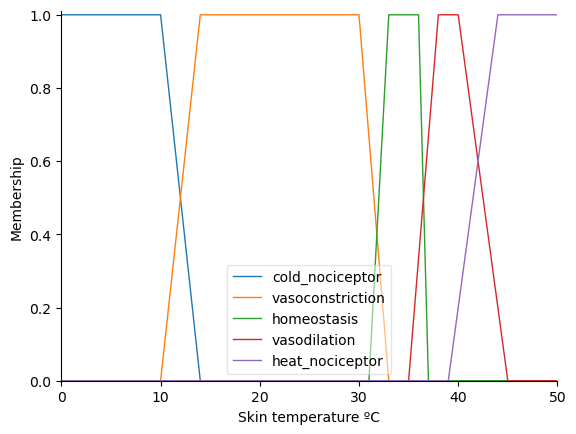

In [3]:
t_skin = ctrl.Antecedent(np.arange(0, 51, 1), 'Skin temperature ºC')
t_skin['cold_nociceptor'] = fuzz.trapmf(t_skin.universe, [0,0,10,14])
t_skin['vasoconstriction'] = fuzz.trapmf(t_skin.universe, [10,14,30,33])
t_skin['homeostasis'] = fuzz.trapmf(t_skin.universe, [31,33,36,37])
t_skin['vasodilation'] = fuzz.trapmf(t_skin.universe, [35,38,40,45])
t_skin['heat_nociceptor'] = fuzz.trapmf(t_skin.universe, [39,44,50,50])
t_skin.view()

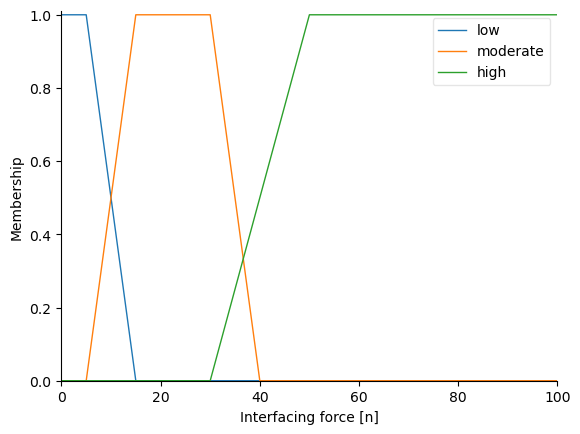

In [4]:
force = ctrl.Antecedent(np.arange(0, 101, 1), 'Interfacing force [n]')
force['low'] = fuzz.trapmf(force.universe, [0,0,5,15])
force['moderate'] = fuzz.trapmf(force.universe, [5,15,30,40])
force['high'] = fuzz.trapmf(force.universe, [30,50,100,100])
force.view()

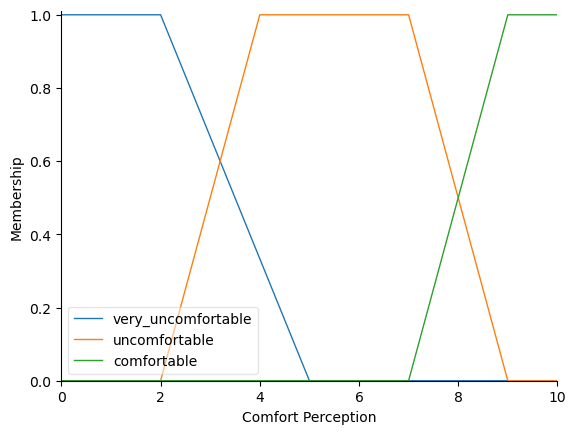

In [5]:
comfort = ctrl.Consequent(np.arange(0,11,1),'Comfort Perception')
comfort['very_uncomfortable'] = fuzz.trapmf(comfort.universe, [0,0,2,5])
comfort['uncomfortable'] = fuzz.trapmf(comfort.universe, [2,4,7,9])
comfort['comfortable'] = fuzz.trapmf(comfort.universe, [7,9,10,10])
comfort.view()

## Rules

(<Figure size 640x480 with 1 Axes>, <Axes: >)

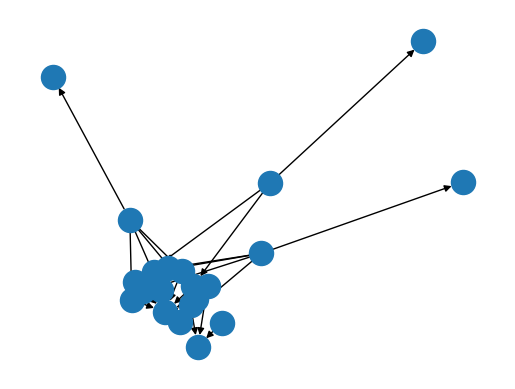

In [6]:
rule0 = ctrl.Rule(antecedent=( (force['high']) |
                               (t_skin['cold_nociceptor']) |
                               (t_skin['heat_nociceptor']) |
                               (t_amb['very_cold'] & t_skin['vasoconstriction']) |
                              (t_amb['very_hot'] & t_skin['vasoconstriction'] ) |
                              (t_amb['cold'] & t_skin['vasoconstriction'] & force['moderate']) |
                              (t_amb['hot'] & t_skin['vasoconstriction'] & force['moderate']) |
                              (t_amb['very_cold'] & t_skin['vasodilation']) |
                              (t_amb['very_hot'] & t_skin['vasodilation'] ) |
                              (t_amb['cold'] & t_skin['vasodilation'] & force['moderate']) |
                              (t_amb['hot'] & t_skin['vasodilation'] & force['moderate']) 
                             ), consequent=comfort['very_uncomfortable'], label='Rule Very Uncomfortable')
rule0.view()

(<Figure size 640x480 with 1 Axes>, <Axes: >)

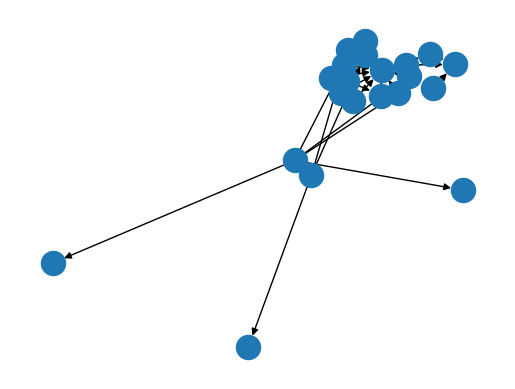

In [7]:
rule1 = ctrl.Rule(antecedent=( (t_amb['very_cold'] & t_skin['homeostasis'] & force['moderate']) |
                                (t_amb['neutral'] & t_skin['vasoconstriction'] & force['moderate']) |
                              (t_amb['neutral'] & t_skin['vasodilation'] & force['moderate']) |
                              (t_amb['very_hot'] & t_skin['homeostasis'] & force['moderate']) |
                               (t_amb['cold'] & t_skin['vasoconstriction'] & force['low']) |
                               (t_amb['neutral'] & t_skin['vasodilation'] & force['low']) |
                              (t_amb['neutral'] & t_skin['vasoconstriction'] & force['low']) |
                               (t_amb['hot'] & t_skin['vasodilation'] & force['low']) |
                               (t_amb['hot'] & t_skin['vasoconstriction'] & force['low']) |
                               (t_amb['very_hot'] & t_skin['homeostasis'] & force['low']) |
                              (t_amb['very_cold'] & t_skin['homeostasis'] & force['low']) |
                              (t_amb['cold'] & t_skin['vasodilation'] & force['low']) 
                               
                             ), consequent=comfort['uncomfortable'], label='Rule Uncomfortable')
rule1.view()

(<Figure size 640x480 with 1 Axes>, <Axes: >)

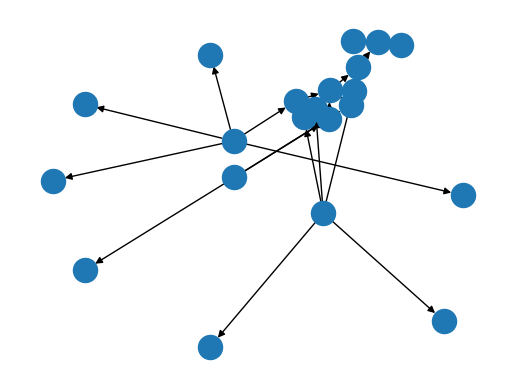

In [8]:
rule2 = ctrl.Rule(antecedent=( (t_amb['cold'] & t_skin['homeostasis'] & force['moderate']) |
                               (t_amb['cold'] & t_skin['homeostasis'] & force['low']) |
                               (t_amb['hot'] & t_skin['homeostasis'] & force['moderate']) |
                               (t_amb['hot'] & t_skin['homeostasis'] & force['low']) |
                               (t_amb['neutral'] & t_skin['homeostasis'] & force['moderate']) |
                               (t_amb['neutral'] & t_skin['homeostasis'] & force['low']) 
                             ), consequent=comfort['comfortable'], label='Rule Comfortable')
rule2.view()

## Build predictor

In [9]:
control_predictor = ctrl.ControlSystem(rules=[rule0, rule1, rule2])
sim = ctrl.ControlSystemSimulation(control_predictor, flush_after_run = 100 * 100)

### Simulate prediction law

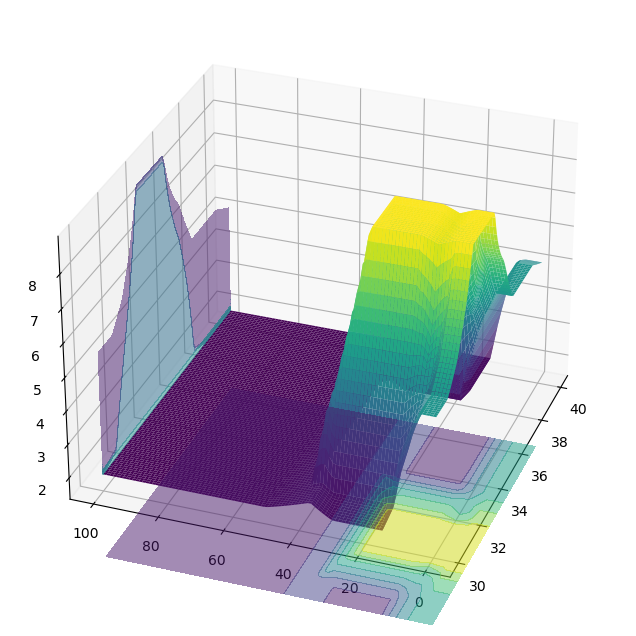

In [10]:
#Fixed ambient temperature, variable body temp, and interfacing force between safe values
unsampled_t = np.linspace(30,40,100)
unsampled_f = np.linspace(0,100,100)
x, y = np.meshgrid(unsampled_t, unsampled_f)
z = np.zeros_like(x)

#Loop through the system

# Lowest today temperature
for i in range(100):
    for j in range(100):
        sim.input['Ambient temperature ºC'] = 17
        sim.input['Skin temperature ºC'] = x[i,j]
        sim.input['Interfacing force [n]'] = y[i,j]
        sim.compute()
        z[i, j] = sim.output['Comfort Perception']

        
# Plot the result in pretty 3D with alpha blending

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0.4, antialiased=True)

cset = ax.contourf(x, y, z, zdir='z', offset=-0.7, cmap='viridis', alpha=0.5)
cset = ax.contourf(x, y, z, zdir='x', offset=3, cmap='viridis', alpha=0.5)
cset = ax.contourf(x, y, z, zdir='y', offset=100, cmap='viridis', alpha=0.5)

ax.view_init(30,200)


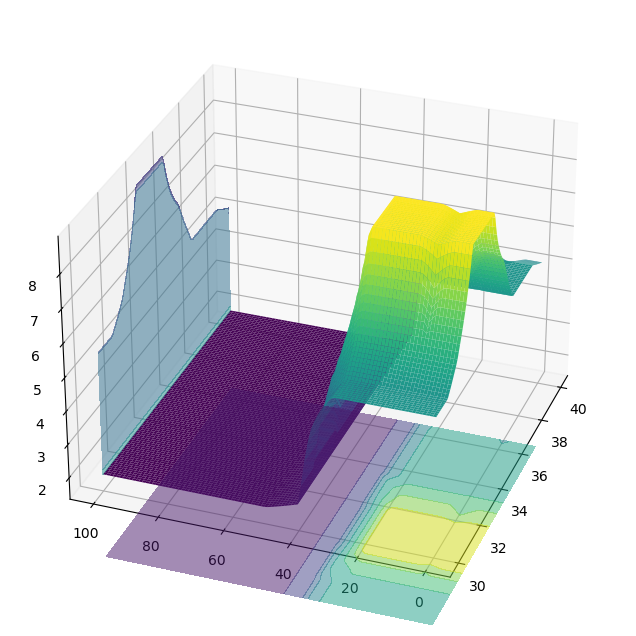

In [11]:
# Mean today temperature
for i in range(100):
    for j in range(100):
        sim.input['Ambient temperature ºC'] = 25
        sim.input['Skin temperature ºC'] = x[i,j]
        sim.input['Interfacing force [n]'] = y[i,j]
        sim.compute()
        z[i, j] = sim.output['Comfort Perception']

        
# Plot the result in pretty 3D with alpha blending

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0.4, antialiased=True)

cset = ax.contourf(x, y, z, zdir='z', offset=-0.7, cmap='viridis', alpha=0.5)
cset = ax.contourf(x, y, z, zdir='x', offset=3, cmap='viridis', alpha=0.5)
cset = ax.contourf(x, y, z, zdir='y', offset=100, cmap='viridis', alpha=0.5)

ax.view_init(30, 200)

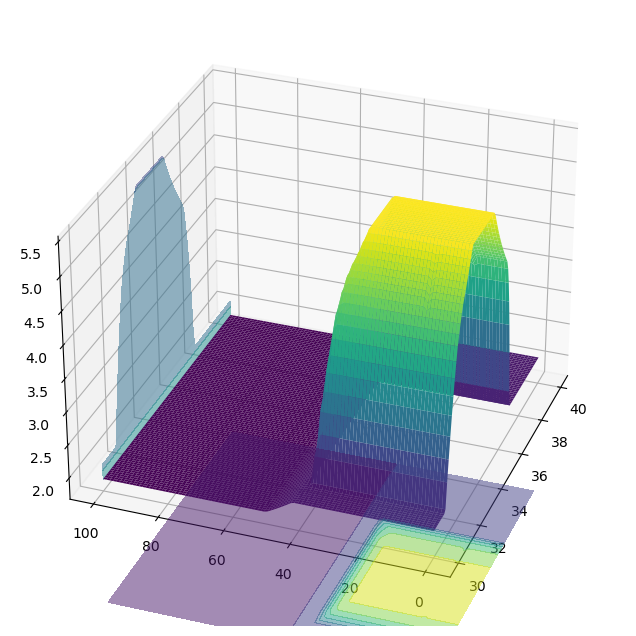

In [12]:
for i in range(100):
    for j in range(100):
        sim.input['Ambient temperature ºC'] = 33
        sim.input['Skin temperature ºC'] = x[i,j]
        sim.input['Interfacing force [n]'] = y[i,j]
        sim.compute()
        z[i, j] = sim.output['Comfort Perception']

        
# Plot the result in pretty 3D with alpha blending

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0.4, antialiased=True)

cset = ax.contourf(x, y, z, zdir='z', offset=-0.1, cmap='viridis', alpha=0.5)
cset = ax.contourf(x, y, z, zdir='x', offset=3, cmap='viridis', alpha=0.5)
cset = ax.contourf(x, y, z, zdir='y', offset=100, cmap='viridis', alpha=0.5)

ax.view_init(30, 200)